# Directional semivariograms - tutorial

## Table of Contents:

1. Read point data,
2. Create directional and isotropic semivariograms,
3. Compare semivariograms.

## Level: Basic

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2022-09-XX | The first version of tutorial | @SimonMolinsky |

## Introduction

In this tutorial, we will learn about directional semivariograms, how to set the angle of `direction` and what's the `tolerance` parameter.

Not every spatial process may be described by isotropic semivariograms and sometimes we see a specific trend in one direction (N-S, W-E, or NE-SW, NW-SE). A well performed analysis includes directions, that's why we will learn how to write a code in `pyinterpolate` that retrieves the directional variogram.

We use the air pollution data downloaded with the package.

## Import packages

In [4]:
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

# IO - read text
from pyinterpolate import download_air_quality_poland
# Experimental variogram
from pyinterpolate import build_experimental_variogram
# Theoretical Variogram
from pyinterpolate import TheoreticalVariogram, build_theoretical_variogram

# 1) Read and show point data

In [2]:
ds = download_air_quality_poland('PM10')
ds.head()

,station_id,y,x,PM10
0,291,52.143250,19.233225,20.00000
1,659,50.529892,22.112467,7.62000
2,459,49.293564,19.960083,6.93902
3,736,54.380279,18.620274,8.25581
4,805,50.329111,19.231222,6.52195


In [9]:
def df2gdf(df, lon_col='x', lat_col='y', epsg=4326, crs=None):
    """
    Function transforms DataFrame into GeoDataFrame.
    
    Parameters
    ----------
    df : pandas DataFrame
    
    lon_col : str, default = 'x'
        Longitude column name.
        
    lat_col : str, default = 'y'
        Latitude column name.
        
    epsg : Union[int, str], default = 4326
        EPSG number of projection.
        
    crs : str, default = None
        Coordinate Reference System of data.
        
    Returns
    -------
    gdf : GeoPandas GeoDataFrame
        GeoDataFrame with set geometry column ('geometry'), CRS, and all columns from the passed DataFrame.
    
    """
    
    gdf = gpd.GeoDataFrame(df)
    gdf['geometry'] = gpd.points_from_xy(x=df[lon_col], y=df[lat_col])
    gdf.geometry = gdf['geometry']
    
    if crs is None:
        gdf.set_crs(epsg=epsg, inplace=True)
    else:
        gdf.set_crs(crs=crs, inplace=True)
        
    return gdf

In [10]:
gds = df2gdf(ds)
gds.head()

,station_id,y,x,PM10,geometry
0,291,52.143250,19.233225,20.00000,POINT (19.23323 52.14325)
1,659,50.529892,22.112467,7.62000,POINT (22.11247 50.52989)
2,459,49.293564,19.960083,6.93902,POINT (19.96008 49.29356)
3,736,54.380279,18.620274,8.25581,POINT (18.62027 54.38028)
4,805,50.329111,19.231222,6.52195,POINT (19.23122 50.32911)


Text(0.5, 1.0, 'PM10 concentrations in Poland')

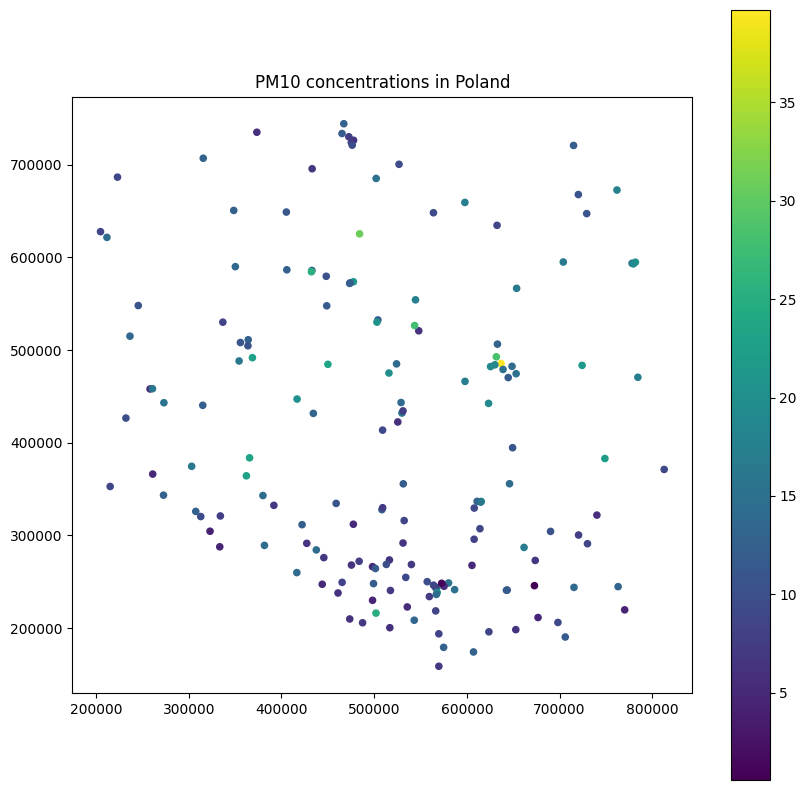

In [15]:
gds.to_crs(epsg=2180, inplace=True)
gds.plot(figsize=(10, 10), column='PM10', legend=True, markersize=20)
plt.title('PM10 concentrations in Poland')

## 2) Create the experimental semivariograms

If we recall the tutorial `Semivariogram Estimation`, there are three main parameters to set for the `build_experimental_variogram()` function:

1. `input_array`: `numpy array` with coordinates and observed values, for example `[[0, 0, 10], [0, 1, 20]]`,
2. `step_size`: we must divide our area of analysis into discrete **lags**. **Lags** are intervals (usually circular) within which we check if the point has a neighbor. For example, if we look into the lag `500`, then we are going to compare one point with other points in a distance `(0, 1000]` from this point,
3. `max_range`: it is a tricky one, and it is hard to guess it at the first try. This parameter represents the possible **maximum range of spatial dependency**. This parameter shouldn't exceed half of the extent.

But that's not everything!

We didn't use two other parameters:

4. `direction`: it is a `float` in range [0, 360]. We set the direction of semivariogram:
    * 0 or 180: is NS direction,
    * 90 or 270 is EW direction,
    * 45 or 225 is NE-SW direction,
    * 135 or 315 is NW-SE direction.

5. `tolerance`: it is a `float` in range [0, 1]. If we leave `tolerance` with default **1**, we will always get isotropic semivariogram. Other edge case is if we set `tolerance` to **0**, then points must be placed on a single line with the beginning in the origin of the coordinate system and the angle given by y axis and direction parameter. If tolerance is > 0 and < 1 then the bin is selected as an elliptical area with major axis pointed in the same direction as the line for 0 tolerance.
    * The minor axis size is `(tolerance * step_size)`,
    * The major axis size is `((1 - tolerance) * step_size)`,
    * The baseline point is at a center of the ellipse.
    
The best idea is to visualize a few different scenarios:

In [16]:
# TODO: vis

Now, when we understand how our parameters affect semivariogram bins range, we can start analysis. We will set `tolerance` to 0.5 in each case to avoid additional complexity.

### Case 1: N-S Direction

In [22]:
BIN_RADIUS = 50000  # meters
MAX_RANGE = 400000  # meters

In [18]:
inp_arr = np.array(list(zip(gds['geometry'].x, gds['geometry'].y, gds['PM10'])))

array([5.15955066e+05, 4.75262934e+05, 2.00000000e+01])

In [26]:
max(inp_arr[:, -1])

39.7

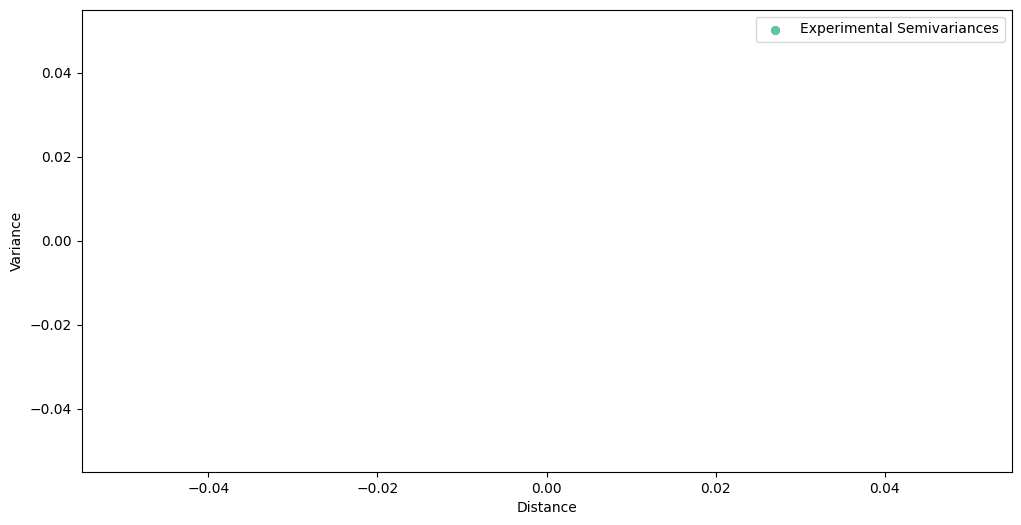

array([nan, nan, nan, nan, nan, nan, nan])

In [24]:
ns_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=0,
    tolerance=0.5
)

ns_variogram.plot(plot_semivariance=True)
ns_variogram.experimental_semivariances

### Case 2: W-E Direction

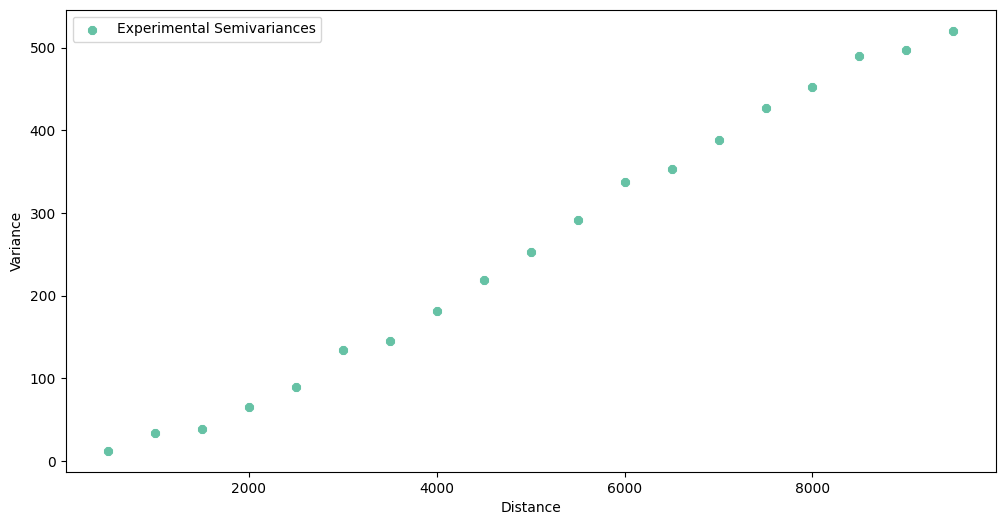

In [7]:
we_variogram = build_experimental_variogram(
    input_array=inp_arr,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=90,
    tolerance=0.5
)

we_variogram.plot(plot_semivariance=True)

### Case 3: NE-SW Direction

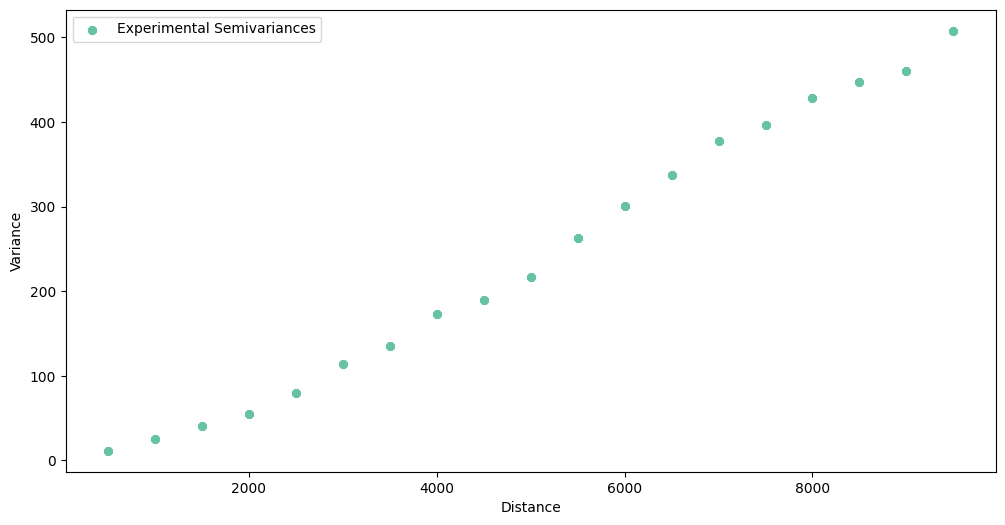

In [8]:
ne_sw_variogram = build_experimental_variogram(
    input_array=dem,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=45,
    tolerance=0.5
)

ne_sw_variogram.plot(plot_semivariance=True)

### Case 4: NW-SE Direction

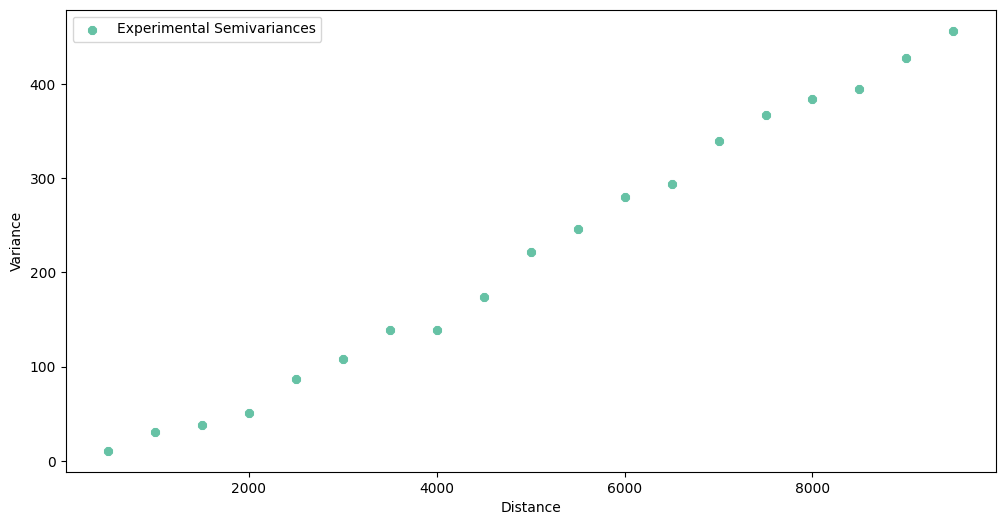

In [16]:
nw_se_variogram = build_experimental_variogram(
    input_array=dem,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE,
    direction=135,
    tolerance=0.5
)

nw_se_variogram.plot(plot_semivariance=True)

### Case 5: Isotropic Variogram

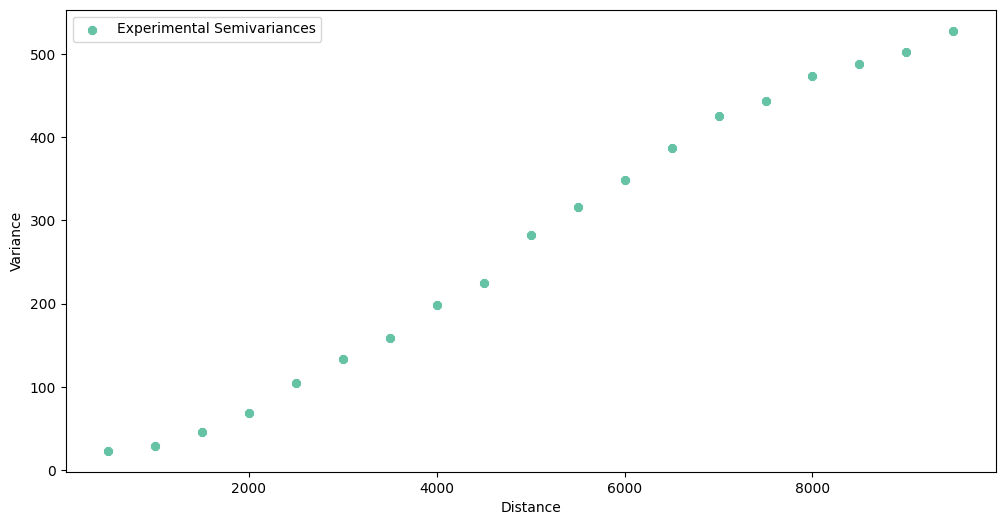

In [10]:
iso_variogram = build_experimental_variogram(
    input_array=dem,
    step_size=BIN_RADIUS,
    max_range=MAX_RANGE
)

iso_variogram.plot()

## 3) Compare semivariograms

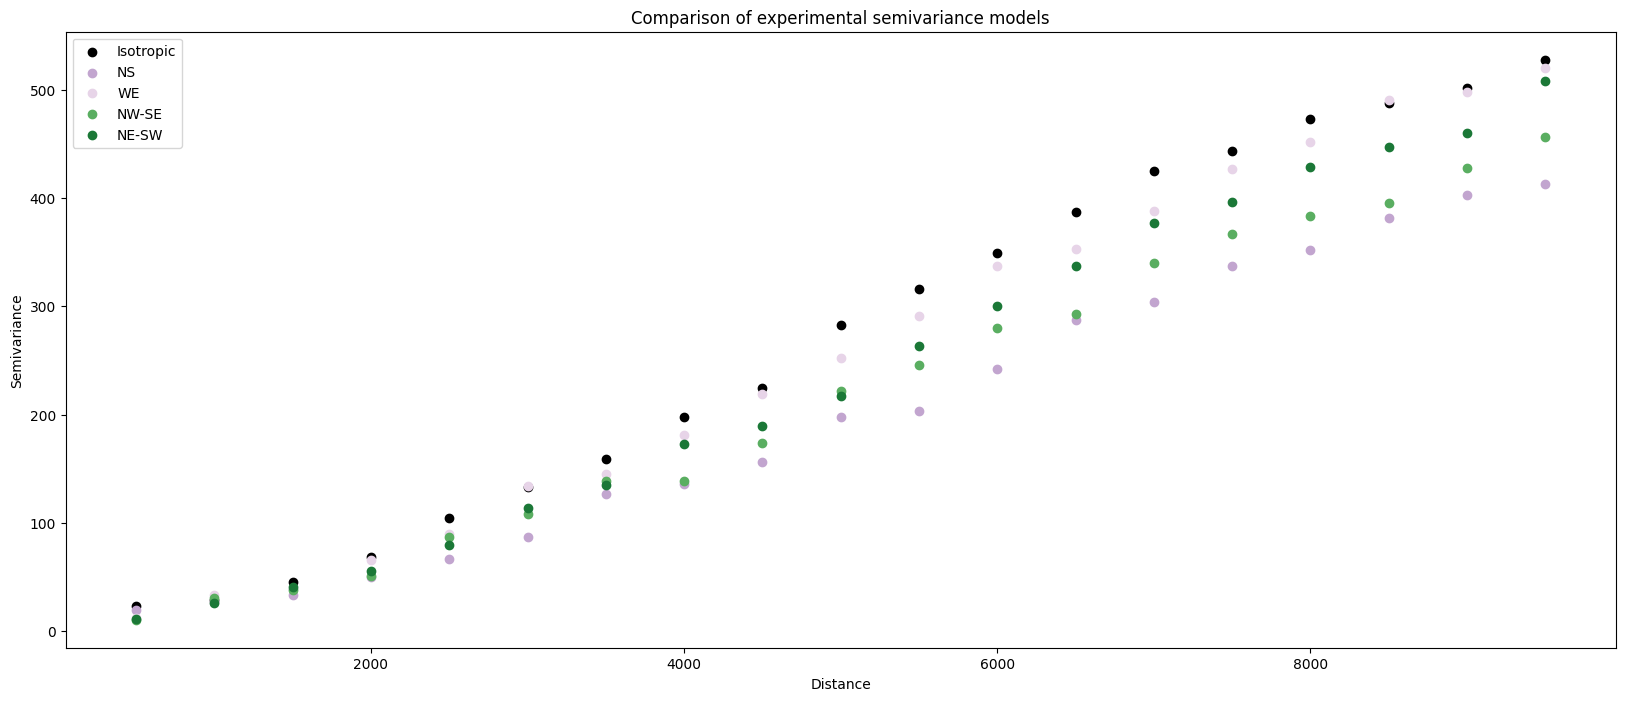

In [17]:
_lags = iso_variogram.lags
_ns = ns_variogram.experimental_semivariances
_we = we_variogram.experimental_semivariances
_nw_se = nw_se_variogram.experimental_semivariances
_ne_sw = ne_sw_variogram.experimental_semivariances
_iso = iso_variogram.experimental_semivariances

plt.figure(figsize=(20, 8))
plt.scatter(_lags, _iso, color='black')
plt.scatter(_lags, _ns, color='#c2a5cf')
plt.scatter(_lags, _we, color='#e7d4e8')
plt.scatter(_lags, _nw_se, color='#5aae61')
plt.scatter(_lags, _ne_sw, color='#1b7837')
plt.title('Comparison of experimental semivariance models')
plt.legend(['Isotropic',
            'NS',
            'WE',
            'NW-SE',
            'NE-SW'])
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.show()